In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import rioxarray
from datetime import datetime
import glob
import os
import contextily as ctx

### Read in Downloaded ASO Flight and create dataframe to identify them

In [2]:
aso_dir = '/home/etboud/projects/data/aso/'
count_check = len(glob.glob(aso_dir+"*.tif"))

for file in os.listdir(aso_dir):
    fn = glob.glob(aso_dir + "*tif")
    ID_shp = [id.split("/")[-1] for id in fn]
    
    df = pd.DataFrame(data = {
    "filepath": fn, 
    "filename":  [i.split("/")[-1] for i in fn],
    "ID": [id.split("/")[-1].split('.')[0] for id in fn],
    "date": [datetime.strptime(flight.split("/")[-1].split('.')[0].split('_')[-1],'%Y%m%d') for flight in fn],
    "code":[region.split("/")[-1].split('.')[0].split('_')[-2] for region in fn]
    })
    df = df.sort_values("filename", ascending = True)
    
if df.shape[0]!=count_check:
    print("Sanity check didn't pass")

In [3]:
df.set_index('date',inplace=True)

#### Add day of year and day of water year column to dataframe for ASO flights

In [4]:
#curr_y = pd.to_datetime("today").year
#curr_y

#Add DOY and DOWY column
#Need to revisit for leap year support
def add_dowy(df, col=None):
    if col is None:
        df['doy'] = df.index.dayofyear
    else:
        df['doy'] = df[col].dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [5]:
#run once
add_dowy(df)
df.sort_index(inplace=True)

#### Filter dataframe to only Tuolumne flights
Open each ASO flight as a rioxarray object, determine pixel resolution, reproject to EPSG: 4326, create an array of only positive snow depth values which will represent snow cover.

In [6]:
#tuo_df = df[df['code']=='USCATB']
# Filter the DataFrame
tuo_df = df[df['code'].isin(['USCATB', 'USCATE', 'USCACE'])]
shp_gdf = gpd.read_file('/home/etboud/projects/data/shp_out/tuolumne.shp')
def sc_ratio(df):
    fp = df['filepath']
    for index, row in df.iterrows():
        fp = row['filepath']
        code = row['code']
        rio_aso = rioxarray.open_rasterio(fp, mask_and_scale=True)
        rio_aso = rio_aso.rio.clip(shp_gdf.geometry.values, crs=shp_gdf.crs, drop=True)
        rio_proj = rio_aso.rio.reproject("EPSG:4326",nodata=np.nan)
        rio_proj_pos = rio_proj.where((rio_proj>0)&(rio_proj<1000))
        tot_pix_num = rio_proj.count()
        sc_pix_num = rio_proj_pos.count()
        # get ~50m resolution
        x_res = abs(rio_aso.x[1] - rio_aso.x[0])
        y_res = abs(rio_aso.y[1] - rio_aso.y[0])
        # count number of total number of pixels, including zeros & nan
        tot_pix_num = rio_proj.count()
        # count number of snow pixels
        sc_pix_num = rio_proj_pos.count()

        # calculate total area including zeros & nans 
        tot_area = tot_pix_num*x_res*y_res
        # calculate snow covered area 
        sc_area = sc_pix_num*x_res*y_res

        sc_ratio = sc_area/tot_area
                                
        df.loc[index,'sc_ratio'] = sc_ratio
        df.loc[index,'sc_area'] = sc_area
        
sc_ratio(tuo_df)

/tmp/ipykernel_1069801/153849549.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index,'sc_ratio'] = sc_ratio
/tmp/ipykernel_1069801/153849549.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index,'sc_area'] = sc_area


#### Identify Early, Mid, and Late Season
Using the snow covered area ratio, identify early(<25%), mid (25%-75%), and late season (>75%). 

In [7]:
def add_season(df):
    # Initialize an empty list to store the season values
    season = []
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        if row['sc_ratio'] > df['sc_ratio'].describe()['75%']:
            season.append('Early')
        elif row['sc_ratio'] < df['sc_ratio'].describe()['25%']:
            season.append('Late')
        else:
            season.append('Mid')
    # Assign the list of season values to a new column in the DataFrame
    df['season'] = season


In [8]:
add_season(tuo_df)

/tmp/ipykernel_1069801/2665388679.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['season'] = season


#### Test plotting on one file

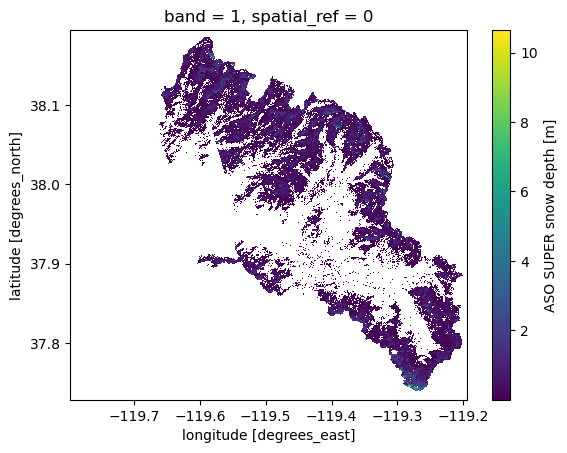

In [45]:

fp = tuo_df.iloc[0]['filepath']
rio_aso = rioxarray.open_rasterio(fp, mask_and_scale=True)
rio_aso = rio_aso.rio.clip(shp_gdf.geometry.values, crs=shp_gdf.crs, drop=True)
rio_proj = rio_aso.rio.reproject("EPSG:4326",nodata=np.nan)
rio_proj_pos = rio_proj.where((rio_proj>0)&(rio_proj<1000))
rio_proj_pos.plot()

In [9]:
early_df = tuo_df[tuo_df['sc_ratio']>tuo_df['sc_ratio'].describe()['75%']]
mid_df = tuo_df[(tuo_df['sc_ratio']>tuo_df['sc_ratio'].describe()['25%'])&(tuo_df['sc_ratio']<tuo_df['sc_ratio'].describe()['75%'])]
late_df = tuo_df[tuo_df['sc_ratio']<tuo_df['sc_ratio'].describe()['25%']]

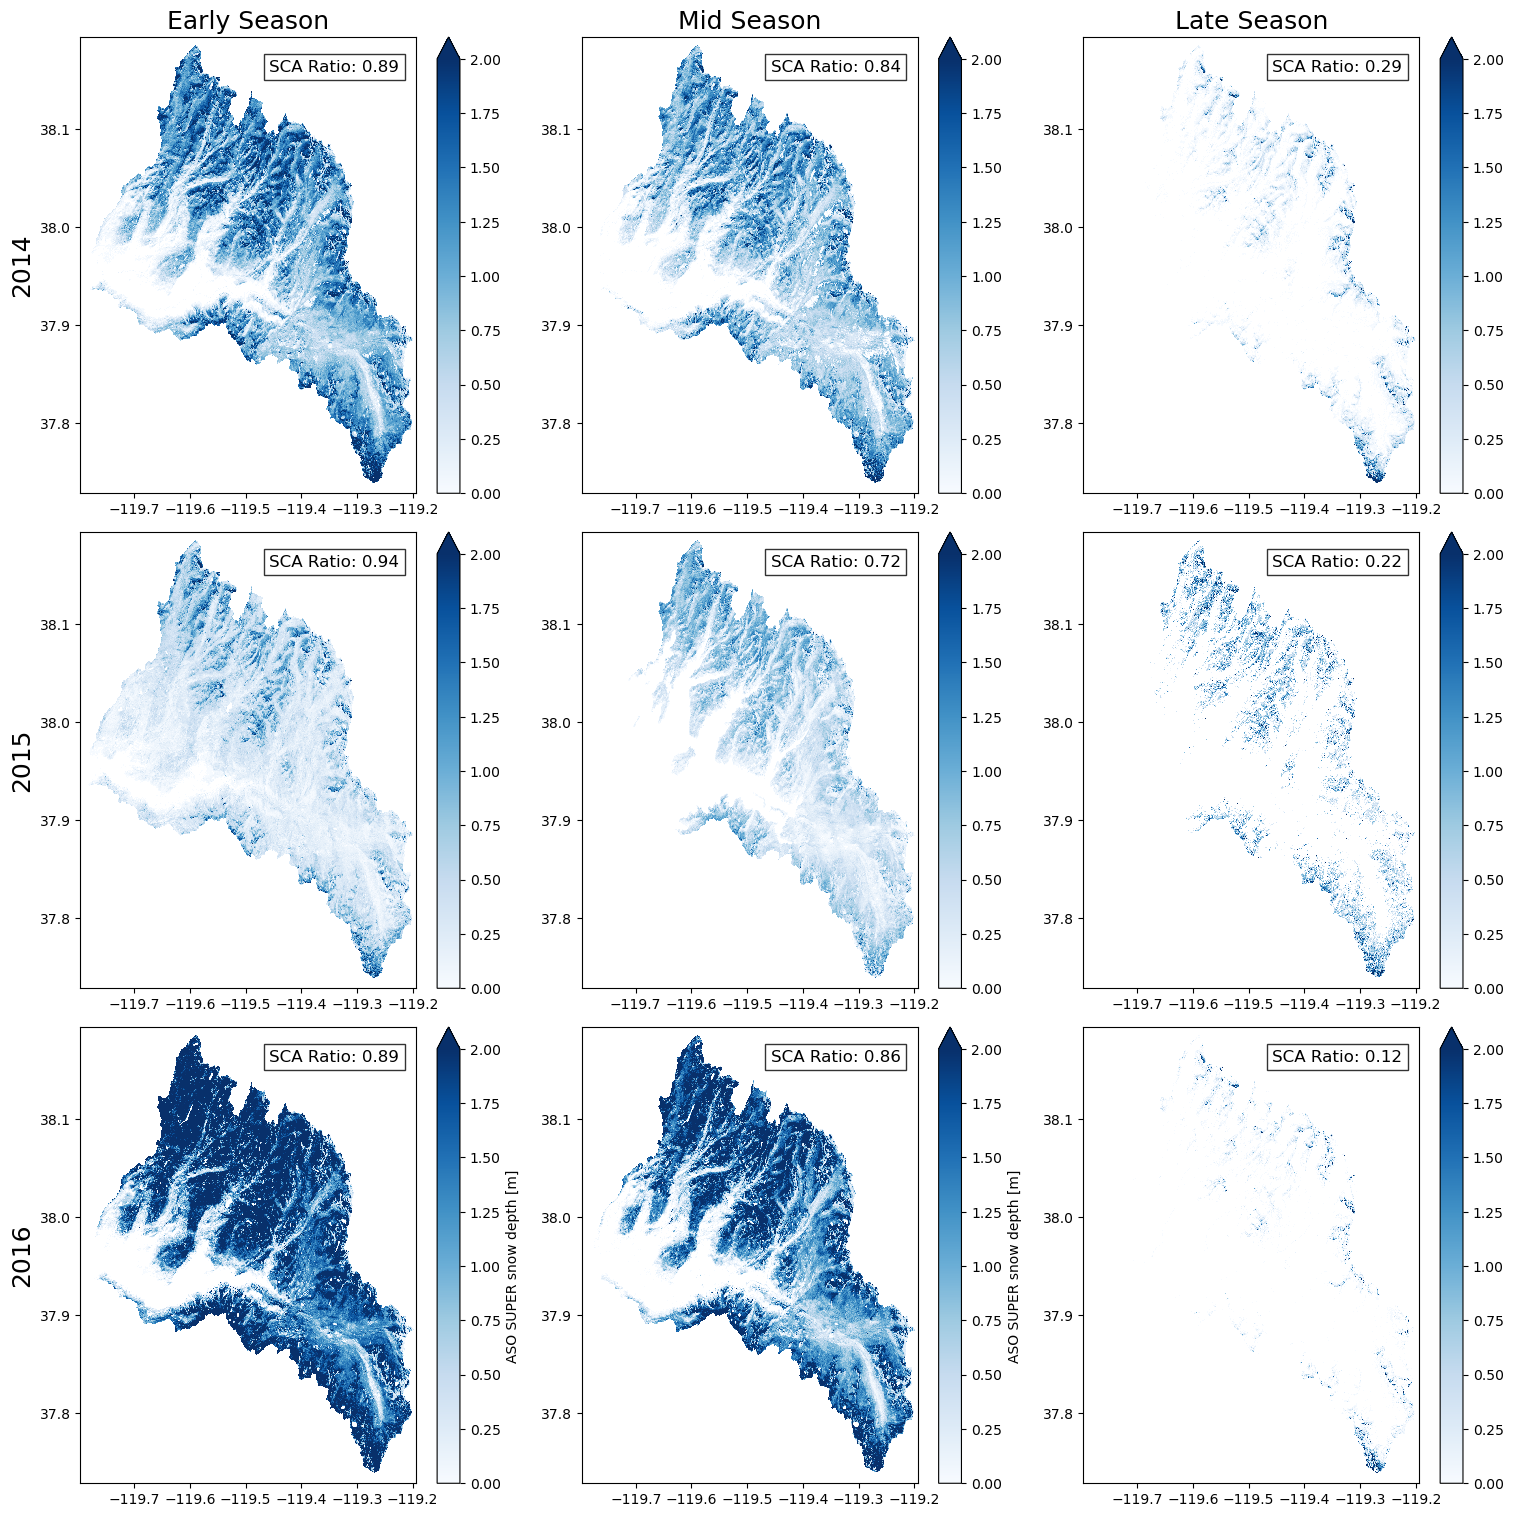

In [19]:
# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over years and categories
for i, year in enumerate([2014, 2015, 2016]):
    for j, season in enumerate(['Early', 'Mid', 'Late']):
        # Select the data for the specific year and season
        if season == 'Mid':
            median_sc_ratio = tuo_df[(tuo_df.index.strftime('%Y') == str(year)) & (tuo_df['season'] == season)]['sc_ratio'].median()
        
        df = tuo_df[(tuo_df.index.strftime('%Y') == str(year)) & (tuo_df['season'] == season)]
        
        # Plot the data if there is at least one row
        if not df.empty:
            fp = df.iloc[0]['filepath']  # Get the filepath from the first row
            rio_aso = rioxarray.open_rasterio(fp, mask_and_scale=True)
            rio_aso = rio_aso.rio.clip(shp_gdf.geometry.values, crs=shp_gdf.crs, drop=True)
            rio_proj = rio_aso.rio.reproject("EPSG:4326", nodata=np.nan)
            rio_proj_pos = rio_proj.where((rio_proj > 0) & (rio_proj < 1000))
            plot = rio_proj_pos.plot(ax=axes[i, j],cmap='Blues',vmin=0,vmax=2)  # Plot rio_proj_pos on the current subplot
            
            # Calculate and add sc_ratio label to top right corner of the plot
            sc_ratio_label = f'SCA Ratio: {df.iloc[0]["sc_ratio"]:.2f}'
            axes[i, j].text(0.95, 0.95, sc_ratio_label, transform=axes[i, j].transAxes,
                            verticalalignment='top', horizontalalignment='right', color='black', fontsize=12,
                            bbox=dict(facecolor='white', alpha=0.8))
            
        # Set title and labels for the subplot
        
            #axes[i, j].set_title(f'{season} Season\nMedian sc_ratio: {median_sc_ratio:.2f}', fontsize=12)
        
            axes[i, j].set_title('')
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel('')

# Adjust layout
plt.tight_layout()
axes[0,0].set_title('Early Season',fontsize= 18)
axes[0,1].set_title('Mid Season',fontsize=18)
axes[0,2].set_title('Late Season',fontsize=18)
axes[0,0].set_ylabel('2014',fontsize=18)
axes[1,0].set_ylabel('2015',fontsize=18)
axes[2,0].set_ylabel('2016',fontsize=18)


plt.show()

/tmp/ipykernel_1069801/977247084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_df['Season'] = 'Early'
/tmp/ipykernel_1069801/977247084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_df['Season'] = 'Mid'
/tmp/ipykernel_1069801/977247084.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

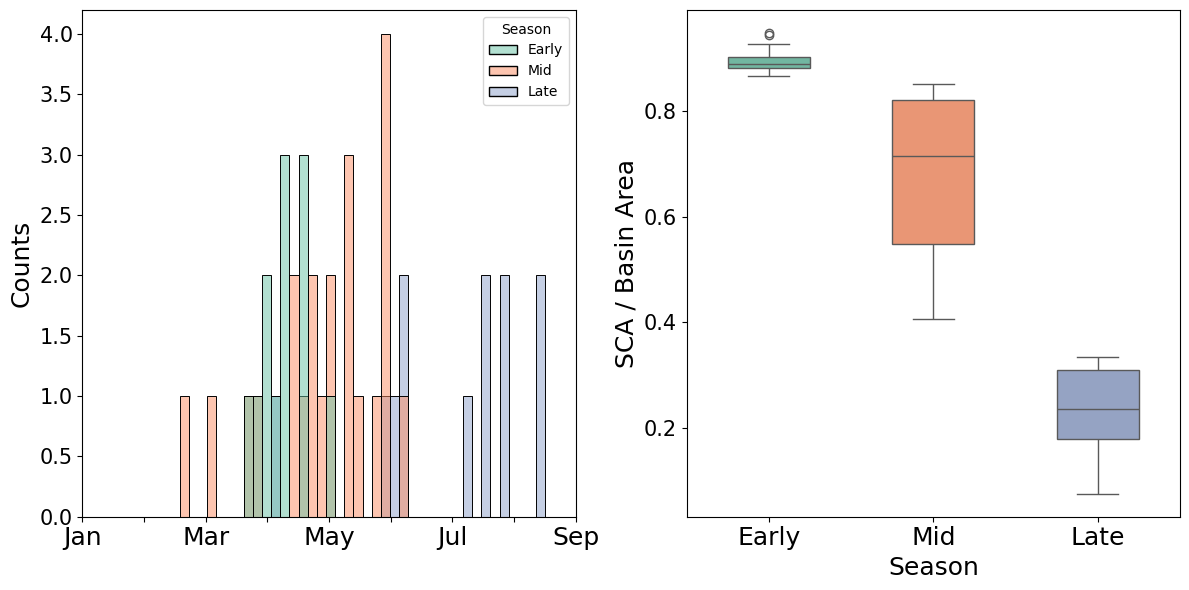

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

early_df['Season'] = 'Early'
mid_df['Season'] = 'Mid'
late_df['Season'] = 'Late'

combined_df = pd.concat([early_df, mid_df, late_df])
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot histograms using Seaborn
sns.histplot(combined_df, x='doy', hue='Season', fill=True, palette='Set2', bins=40, ax=axes[0])
sns.boxplot(data=combined_df, x="Season", y="sc_ratio", width=.5,palette='Set2', ax=axes[1])
# Set x-lim to September and label every other month
axes[0].set_xlim(0, 243)  # September is approximately 243 days into the year
months = ['Jan', '', 'Mar', '', 'May', '', 'Jul', '', 'Sep']
axes[0].set_xticks(np.linspace(0, 243, 9))
axes[0].set_xticklabels(months, fontsize=18)
axes[0].set_ylabel('Counts',fontsize=18)
axes[1].set_xlabel('Season', fontsize=18)
axes[1].set_ylabel('SCA / Basin Area',fontsize =18)
axes[1].set_xticklabels(['Early', 'Mid', 'Late'], fontsize=18)
axes[0].set_xlabel('')  # Removing x-label for the histogram
axes[1].tick_params(axis='y', labelsize=15) 
axes[0].tick_params(axis='y', labelsize=15) 
plt.tight_layout()
plt.show()

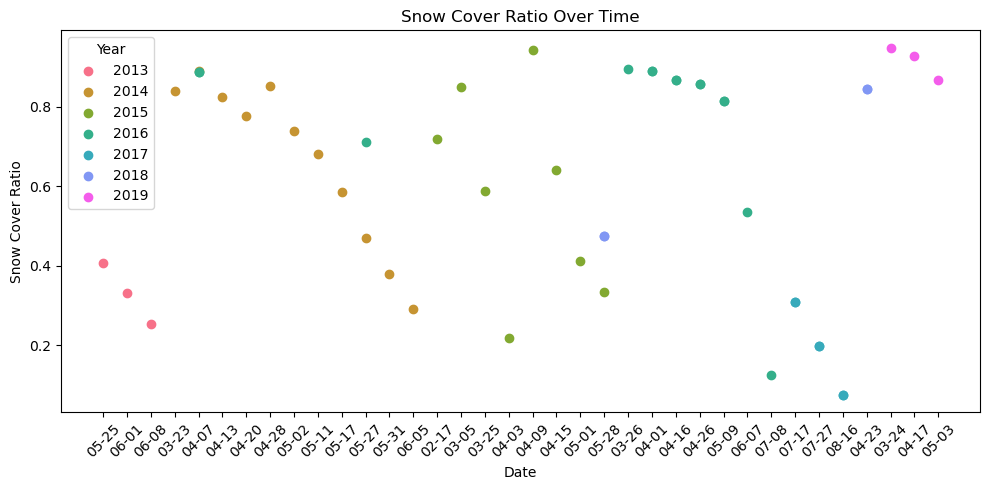

In [21]:

# Group the DataFrame by year
grouped_df = tuo_df.groupby(tuo_df.index.year)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Define a colormap for different years
colors = plt.cm.viridis(np.linspace(0, 1, len(grouped_df)))
colors = sns.color_palette("husl", len(grouped_df))

# Plot each group (year) separately
for i, (year, group) in enumerate(grouped_df):
    group_sorted = group.sort_index()
    ax.scatter(pd.to_datetime(group_sorted.index).strftime('%m-%d'), group_sorted['sc_ratio'], marker='o',  color=colors[i], label=str(year))

# Set labels and title
ax.set_xlabel('')
ax.set_ylabel('Snow Cover Ratio')
ax.set_title('Snow Cover Ratio Over Time')



# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend(title='Year')

# Show plot
plt.tight_layout()
plt.show()

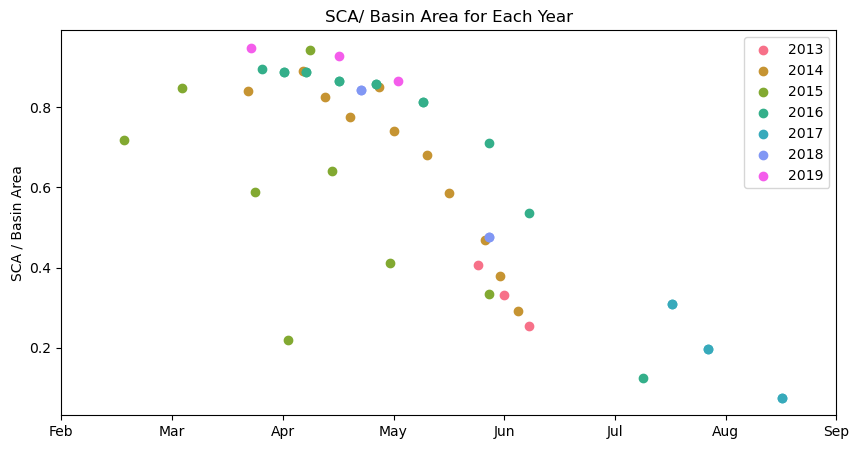

In [22]:
# Create grouped_df
grouped_df = tuo_df.groupby(tuo_df.index.year)
colors = sns.color_palette("husl", len(grouped_df))
# Plotting sc_ratio against doy for each year
fig, ax = plt.subplots(figsize=(10, 5))
for i, (year, group) in enumerate(grouped_df):
    ax.scatter(group['doy'], group['sc_ratio'], label=year, color=colors[i])

# Labeling axes and adding a title

ax.set_title('SCA/ Basin Area for Each Year')
ax.legend()  # Adding a legend with year labels
# Set x-axis labels to month day

months = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
ax.set_xticks(np.linspace(31, 243, 8))
ax.set_xticklabels(months)
ax.set_xlabel('')
ax.set_ylabel('SCA / Basin Area')

plt.show()


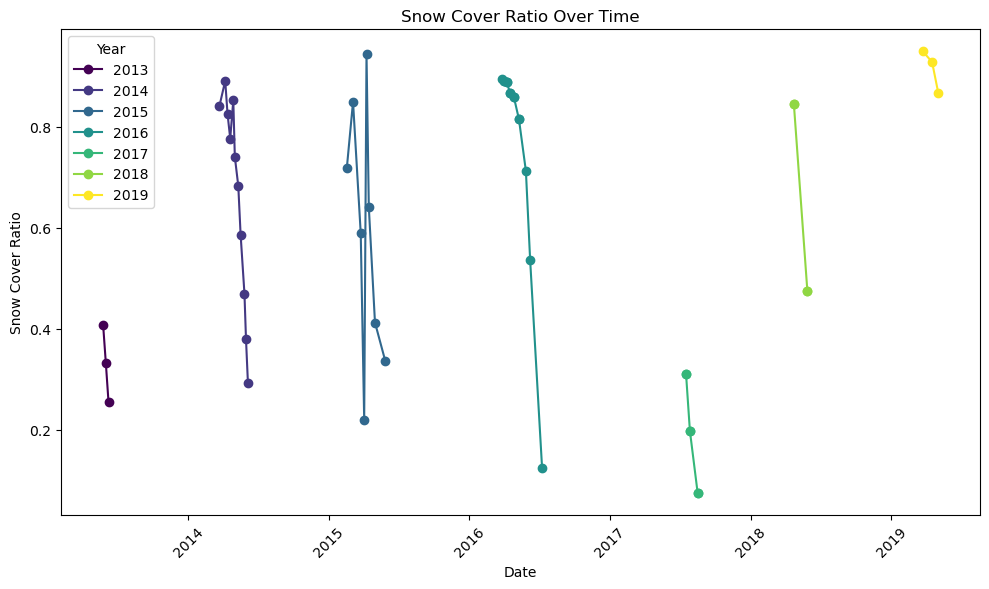

In [41]:

# Group the DataFrame by year
grouped_df = tuo_df.groupby(tuo_df.index.year)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define a colormap for different years
colors = plt.cm.viridis(np.linspace(0, 1, len(grouped_df)))

# Plot each group (year) separately
for i, (year, group) in enumerate(grouped_df):
    ax.plot(group.index, group['sc_ratio'], marker='o', linestyle='-', color=colors[i], label=str(year))

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Snow Cover Ratio')
ax.set_title('Snow Cover Ratio Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend(title='Year')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
#tuo_df[tuo_df.index.strftime('%Y')=='2014'].index.sort
#gb_c = tuo_df.groupby(tuo_df.index.strftime('%m%d%Y')).count()
#gb_c[gb_c['filename']==2]
#tuo_df[(tuo_df.index.strftime('%Y') == '2014')&(tuo_df['season'] == 'Mid')]['sc_ratio'].median()